# Housing Price Prediction

**Goal:** Predict house prices (`price`) from property features using a leakage-safe preprocessing + modeling pipeline, **cross-validated** model selection, and interpretability + error analysis.

## Research question

This project investigates **which property features most strongly drive house prices** and how accurately we can predict the target (`SalePrice`) using supervised learning.

Key questions:
- Which features contribute the most to predictive performance?
- How do linear vs. non-linear models compare under cross-validation?
- What are the main error modes on a held-out test set?

🎯 This project uses the full ML_Houses_dataset.csv dataset consisting of 84 features.
The dataset can be accessed [here](https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv).

Within the scope of this project, the following steps will be performed:

 - Exploring and understanding all features,
 - Applying appropriate preprocessing and encoding techniques,
 - Performing feature engineering to create new meaningful variables,
 - Incorporating engineered features into the model,
 - Applying feature selection methods to evaluate and improve model performance.

## 0. Setup

- Reproducibility with a fixed random seed
- Core libraries: pandas, numpy, scikit-learn, matplotlib

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Loading

Dataset source (provided by you): [here](https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv)

> If you run this in an environment without internet access, download the CSV locally and replace the URL with a local path.

In [3]:
url=" https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv "

In [5]:
data=pd.read_csv(url)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
data.shape

(1760, 85)

## 2. Quick EDA (Exploratory Data Analysis)

In this section, the dataset is explored to understand the distribution of features, missing values, and target variable characteristics.

### 2.1 Data Overview and Cleaning

In this section, the dataset is inspected to understand its general structure, identify missing values and duplicate records, and distinguish between numerical and categorical features. This step ensures that the data is clean and properly prepared before modeling.

In [8]:
display(data.describe(include="all").T)
# Target column
assert "SalePrice" in data.columns, "Expected a target column named 'SalePrice'"

#duplicates
# After loading raw data
print("Shape before cleaning:", data.shape)

# Remove exact duplicate rows
data = data.drop_duplicates().reset_index(drop= True )

print("Shape after removing duplicates:", data.shape)

# Missingness
missing = data.isna().mean().sort_values(ascending=False)
display(missing[missing > 0].to_frame("missing_ratio"))

# Identify column types
X = data.drop(columns=["SalePrice"])
y = data["SalePrice"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))
print("Example numeric:", num_cols[:8])
print("Example categorical:", cat_cols[:8] if cat_cols else "None")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1460.0,NaN,NaN,NaN,6.321918,2.703626,1.0,5.0,6.0,8.0,12.0
YrSold,1460.0,NaN,NaN,NaN,2007.815753,1.328095,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1460,9,WD,1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1460,6,Normal,1198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape before cleaning: (1460, 85)
Shape after removing duplicates: (1460, 85)


,missing_ratio
WallMat,0.996575
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
LotFrontage,0.177397
GarageCond,0.055479
GarageType,0.055479


Numeric columns: 39
Categorical columns: 45
Example numeric: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd']
Example categorical: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope']


### 2.2 Correlation Analysis
In this section, correlation analysis is performed to examine the linear relationships between numerical features and the target variable (SalePrice).
This helps identify which variables are most strongly associated with house prices and provides an initial understanding of potential predictive features.

In [13]:
corr= data.select_dtypes(include=[np.number]).corr()["SalePrice"] \
    .sort_values(ascending=False)
corr

SalePrice        1.000000
Pesos            1.000000
OverallQual      0.790982
GrLivArea        0.707685
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
RoofSurface      0.018043
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorc


*
👇 Due to the large number of numerical features, the full correlation heatmap was visually cluttered and therefore not informative.
For interpretability, only the top correlated features were visualized.

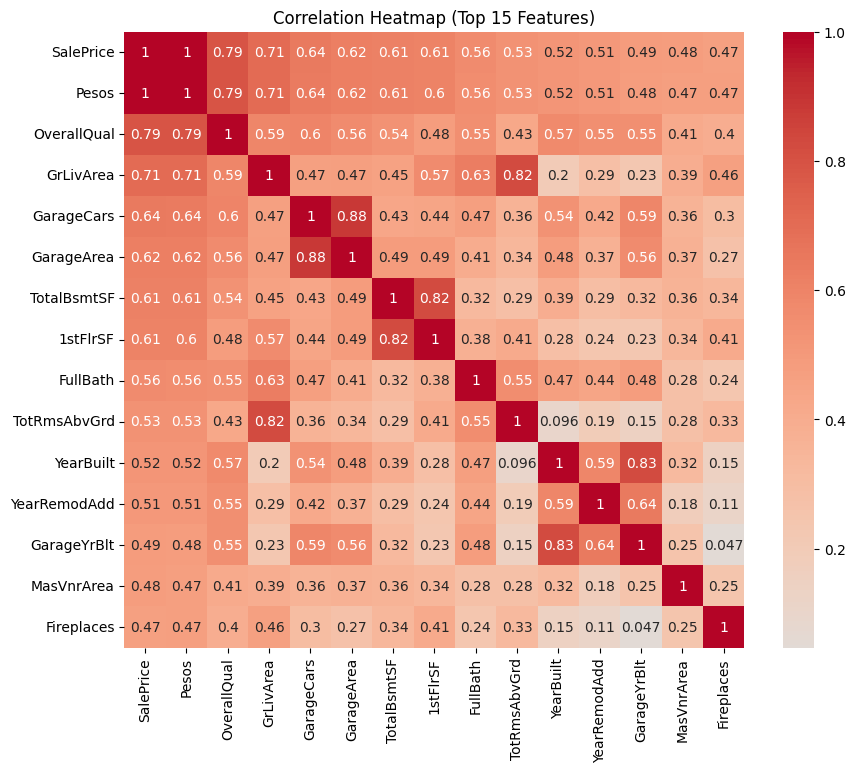

In [14]:
top_corr_features = corr.head(15).index

plt.figure(figsize=(10,8))
sns.heatmap(
    data[top_corr_features].corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap (Top 15 Features)")
plt.show()


* ##### Correlation Analysis Interpretation
“Correlation analysis was conducted prior to model training to identify potential target proxies. This analysis revealed that the variable ‘Pesos’ exhibits a perfect correlation (ρ = 1.00) with the target variable. Based on this finding, the feature was removed before the final model training to prevent data leakage.”

#### 2.2.2 Feature Selection Based on Correlation Analysis
Based on the correlation analysis, weakly correlated features were removed and the feature matrix (X) and target variable (y) were reconstructed.

In [16]:
# Identify column types (again)
X = data.drop(columns=["SalePrice", "Pesos"])
y = data["SalePrice"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]